In [342]:
import pandas as pd

In [343]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")

In [344]:
df.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we are going to perform mathematical operations, we need to convert the pandas dataframe to a numpy array

In [345]:
import numpy as np
data = np.array(df)
m,n = data.shape
print(f"m: {m}")
print(f"n: {n}")

m: 42000
n: 785


So we have 42000 training examples and 784 features each excluding the label column

In [346]:
data[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

First columns is the label and rest are pixel values or the features

In [347]:
data[:5].T

array([[1, 0, 1, 4, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

As we can see after transpose, we get the first row as the label. This makes easy in retrieving the target variable for splitting.

Lets take first 2000 samples after shuffling as validation set and rest as train set

In [348]:
np.random.shuffle(data)
val_data = data[0 : 2000].T
Y_val = val_data[0]
X_val = val_data[1 : n]
X_val = X_val / 255.

In [349]:
train_data = data[2000 : m].T
Y_train = train_data[0]
X_train = train_data[1 : n]
X_train = X_train / 255.

In [350]:
def initialize_parameters():
    """
    This function initializes random values for initial weights and biases of our neural network
    There will be a input layer, one hidden layer with 10 neurons and output layer with 10 neurons representing mnist digits
    """

    W1 = np.random.rand(10, 784) - 0.5
    #returns an array of random values between (0, 1) with the shape (10, 784)
    b1 = np.random.rand(10, 1) - 0.5
    #returns an array of random values between (0, 1) with the shape (10, 1)
    W2 = np.random.rand(10, 10) - 0.5
    #returns an array of random values between (0, 1) with the shape (10, 10)
    b2 = np.random.rand(10, 1) - 0.5
    #returns an array of random values between (0, 1) with the shape (10, 1)

    return W1, b1, W2, b2


In [351]:
def ReLU(Z):
    """
    For each element in Z, the ReLU function returns Z if Z is positive and return 0 if Z is negative
    """
    return np.maximum(Z ,0)

In [352]:
def Softmax(Z):
    """
    The Softmax function converts the final score into probability distribution over different classes
    np.exp(Z) calculates the element-wise exponential of input Z
    np.sum(np.exp(Z)) calculates the sum of the exponentiated values of ell elements of Z
    """
    #Z -= np.max(Z)
    B = np.exp(Z)
    C = sum(np.exp(Z))
    #print(B)
    #print(C)
    A = B / C
    #print(A)
    return A

In [353]:
def one_hot(Y):
    """
    We have our final output as probability distribution over 10 classes
    To calculate the loss, we need to convert the label Y to same format
    So for that , we perform one hot encoding which does something like if label = 3 the, encoded format = (0,0,0,1,0,0,0,0,0,0)
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    #This creates a matrix of required size with zeroes
    one_hot_Y[np.arange(Y.size), Y] = 1
    #This sets the elements in one_hot_Y to 1 based on the class labels Y
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [354]:
def forward_propagation(W1, b1, W2, b2, X):
    #print(X)
    Z1 = W1.dot(X) + b1
    #print(Z1)
    A1 = ReLU(Z1)
    #print(A1)
    Z2 = W2.dot(A1) + b2
    #print(Z2)
    A2 = Softmax(Z2)
    return Z1, A1, Z2, A2

In [355]:
def derative_ReLU(Z):
    """
    This derivative is used to compute the gradients of the loss with respect to the input of the ReLU activation function to optimize our parameters
    """
    #If any element in Z is greater than 0 , return 1 otherwise 0
    return Z > 0

In [356]:
def back_propagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * derative_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)

    return dW1, db1, dW2, db2

In [357]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Use the cost function to update weights and biases
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

    return W1, b1, W2, b2

In [358]:
def prediction(A2):
    """
    returns the index of the maximum value which will be the predicted label
    """
    return np.argmax(A2, 0)

In [359]:
def accuracy(predictions, Y):
    """
    Calculates the accuracy of the model by comparing the predicted labels with the true labels
    """
    return np.sum(predictions == Y) / Y.size

In [360]:
def run(X, Y, alpha, epochs):
    W1, b1, W2, b2 = initialize_parameters()
    for i in range(epochs):
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        #Print the accuracy at every 10th epoch
        if i % 10 == 0:
            print("Epoch:", i)
            predictions = prediction(A2)
            print(f"Accuracy: {accuracy(predictions, Y)}")
            print("~~~~~~~~~~~~~~~~~")

    return W1, b1, W2, b2

In [361]:
W1, b1, W2, b2 = run(X_train, Y_train, 0.10, 500)

Epoch: 0
Accuracy: 0.10215
~~~~~~~~~~~~~~~~~
Epoch: 10
Accuracy: 0.173775
~~~~~~~~~~~~~~~~~
Epoch: 20
Accuracy: 0.239925
~~~~~~~~~~~~~~~~~
Epoch: 30
Accuracy: 0.2965
~~~~~~~~~~~~~~~~~
Epoch: 40
Accuracy: 0.346925
~~~~~~~~~~~~~~~~~
Epoch: 50
Accuracy: 0.392125
~~~~~~~~~~~~~~~~~
Epoch: 60
Accuracy: 0.44515
~~~~~~~~~~~~~~~~~
Epoch: 70
Accuracy: 0.5041
~~~~~~~~~~~~~~~~~
Epoch: 80
Accuracy: 0.550425
~~~~~~~~~~~~~~~~~
Epoch: 90
Accuracy: 0.58875
~~~~~~~~~~~~~~~~~
Epoch: 100
Accuracy: 0.618425
~~~~~~~~~~~~~~~~~
Epoch: 110
Accuracy: 0.64245
~~~~~~~~~~~~~~~~~
Epoch: 120
Accuracy: 0.662825
~~~~~~~~~~~~~~~~~
Epoch: 130
Accuracy: 0.6785
~~~~~~~~~~~~~~~~~
Epoch: 140
Accuracy: 0.69395
~~~~~~~~~~~~~~~~~
Epoch: 150
Accuracy: 0.70655
~~~~~~~~~~~~~~~~~
Epoch: 160
Accuracy: 0.717375
~~~~~~~~~~~~~~~~~
Epoch: 170
Accuracy: 0.7279
~~~~~~~~~~~~~~~~~
Epoch: 180
Accuracy: 0.737725
~~~~~~~~~~~~~~~~~
Epoch: 190
Accuracy: 0.746675
~~~~~~~~~~~~~~~~~
Epoch: 200
Accuracy: 0.755125
~~~~~~~~~~~~~~~~~
Epoch: 210
Accura

In [368]:
def make_predictions(X, W1, b1, W2, b2):
    Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
    predictions = prediction(A2)
    return predictions

In [369]:
val_prediction = make_predictions(X_val, W1, b1, W2, b2)
accuracy(val_prediction, Y_val) * 100

85.65

So we got a solid 85 percent accuracy on the validation set as well

In [370]:
import matplotlib.pyplot as plt

In [371]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  9


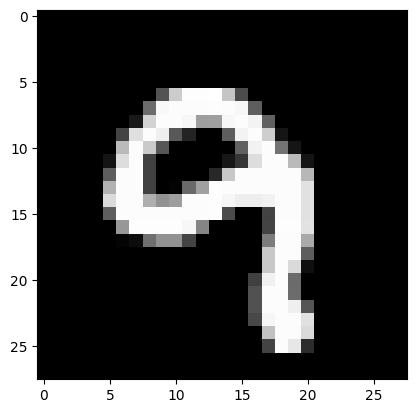

In [372]:
test_prediction(56, W1, b1, W2, b2)